In [49]:
import os # Handle OS file systems and directory paths
import random # Random number
import numpy as np # Import NumPy for arrays and such
import matplotlib.pyplot as plt # Plotting Tools
import numpy.linalg as npl # Linear Algebra Library
import time # Time
# from google.colab import drive # Read files in from Google Drive
import pandas as pd # Import Pandas for data processing
import datetime as dt
import scipy.io as sio
import io
from decimal import Decimal # String to double conversion
from glob import glob  # 从 glob 模块中导入 glob 函数

In [50]:
import boto3
from botocore.exceptions import NoCredentialsError

In [51]:
# Optionally, you can specify the AWS region
s3 = boto3.client('s3', region_name='us-east-1')  # Replace 'us-west-2' with your AWS region

In [52]:
import pandas as pd
# s3_uri = 's3://pepper-dataset/crop_data/crop_IOWA/Iowa_corn_2019.csv'
# df = pd.read_csv(s3_uri)

In [86]:
# get county list
# county_path_list = glob('/content/drive/MyDrive/ai/era5/county_env/*')
# county_list = [os.path.basename(x) for x in county_path_list]
# print(county_list)

#Read files from s3
bucket_name = 'pepper-dataset'
prefix = 'county-env-data/county_env_IOWA/processed_with_all_features_ver_2/'

# List to store all object keys
county_files = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    county_files.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
    
county_files = ["/" + path if not path.startswith("/") else path for path in county_files]

In [87]:
len(county_files)

54648

In [83]:
county_files[:10]

['/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-01_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-01_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-02_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-02_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-03_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-03_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-04_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-04_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2000-05_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_f

In [84]:
# try 1 county
year_range = [2002, 2022]
years = [x for x in range(year_range[0], year_range[-1]+1)]

filtered_files = [file_path for file_path in county_files
                  if any(str(year) in file_path for year in years)]

# basedir = '/content/drive/MyDrive/ai/era5/county_env/'
# county_files = []

# for c in county_list:
#   county = os.path.join(basedir, c)
#   print(county)

#   county_f = glob(os.path.join(county, '*'))

#   for f in county_f:
#     ym_str = f.split('_')[-2]
#     ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
#     if ym_obj.year not in years:
#         continue
#     county_files.append(f)

print(len(filtered_files))

  # print(len(county_files))
  # print(county_files[:3])

# get year-month info for the county
# ym_list = [x.split('_')[-2] for x in county_files]
# ym_list = list(set(ym_list))
# ym_list.sort()
# print(ym_list)

filtered_files[:50]


49896


['/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-01_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-01_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-02_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-02_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-03_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-03_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-04_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-04_part2.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_features/Iowa_Adair/Iowa_Adair_2002-05_part1.csv',
 '/county-env-data/county_env_IOWA/processed_with_all_f

In [85]:
pd.read_csv('s3://'+bucket_name+filtered_files[0])

PermissionError: The operation is not valid for the object's storage class

In [58]:
df_list = pd.DataFrame(columns=("Year","State","County","Month","Commodity","Feature"))

for csvf in filtered_files:
    # only read part1, then match with part2
    if 'part2' in csvf:
        continue
    # print(csvf)
    crop = "UNKNOWN"

    suffix = csvf.split('/')[-1]
    state = suffix.split('_')[-4].upper()
    # print(state)
    if state != "IOWA":
        continue
    county_name = suffix.split('_')[-3].upper()
    ym_str = csvf.split('_')[-2]

    year = int(suffix.split('-')[0][-4:])
    month = int(suffix.split('-')[1][:2])
    ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
    if ym_obj.year not in years:
        continue
    # else:
    #     print(ym_str)
        # pass

    df1 = pd.read_csv('s3://'+bucket_name+csvf)
    # df1.dropna(axis=1)
    csvf_part2 = csvf.replace('part1', 'part2')
    df2 = pd.read_csv('s3://'+bucket_name+csvf_part2)
    # df2.dropna(axis=1)


    df12 = pd.merge(df1, df2, on = 'datetime')
    
    df12 = df12.drop(columns=['sshf'])
    df12 = df12.drop(columns=['evavt'])
    
    df12['datetime'] = pd.to_datetime(df12['datetime'])
    # print("----------------------")
    # print(df12[df12['datetim-e'].dt.month >= 5])
    # df12 = df12[df12['datetime'].dt.month >= 5]
    # print(df12['datetime'].dt.month)
    df12 = df12[(df12['datetime'].dt.month >= 5) & (df12['datetime'].dt.month <= 11)]
    if df12.empty:
        print("No data available after filtering.")
        continue
      # drop datetime
    df12 = df12.drop(columns=['datetime'])
    
    # df12.drop(columns=['datetime'])
    # print(df12.head())
    # print("size:", len(df12))
    # print(df12.dtype)

    # print("-----------------------")
    # print(df12.shape)
    row = [year,state,county_name,month,crop]
    row.append(df12)
    # print(row[:4])

    # df_list.append(df12)
    dfLength = len(df_list)
    df_list.loc[dfLength] = row

# df_all = df_list[0]
# for df in df_list[1:]:
#     df_all = pd.concat([df_all, df], axis = 0)

print("Number of Features Per County Per Year:  >= ",len(df_list.iloc[1,4]))
# print(df_list["State"])
# df_list['Feature'] = df_list['Feature'].astype(object)

# df_list.to_csv('/content/drive/MyDrive/ai/era5/dataSat_cleaned_Iowa_2015-2020.csv', index=False)

No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available af

In [59]:
df_list.shape

(14553, 6)

In [60]:
df_list.iloc[1][-1]

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,299.742409,99.999985,0.0,298.560604,295.131556,287.909226,281.787348,273.159160,0.308476,0.323012,0.353901,0.342547,-0.004873,96505.771405,2.829540e+07,3.181626e+07,7.237522e-08
1,298.164156,99.999985,0.0,297.413008,295.134783,287.941143,281.792699,273.159781,0.308075,0.322784,0.353829,0.342546,-0.000101,96545.021590,4.255381e+05,1.405262e+06,-6.938894e-18
2,296.755970,99.999985,0.0,296.303638,295.066811,287.972684,281.798581,273.159471,0.307965,0.322698,0.353795,0.342549,-0.000132,96559.138902,4.783862e+05,2.827662e+06,4.342513e-07
3,295.784843,99.999985,0.0,295.479584,294.950399,288.003211,281.804071,273.160092,0.307968,0.322642,0.353764,0.342550,-0.000146,96599.258738,4.783862e+05,4.235085e+06,5.355766e-06
4,294.658176,100.061137,0.0,294.888669,294.806215,288.032464,281.809451,273.159160,0.318464,0.322632,0.353738,0.342554,-0.000158,96651.872539,4.783862e+05,5.675611e+06,9.205404e-04
5,292.849871,99.999985,0.0,294.077339,294.622243,288.060037,281.814802,273.160092,0.350834,0.322766,0.353715,0.342556,-0.000161,96740.315905,4.783862e+05,7.090680e+06,3.344676e-03
6,292.190413,99.999985,0.0,293.499361,294.415029,288.086104,281.820544,273.159781,0.350307,0.323013,0.353696,0.342558,-0.000163,96690.398017,4.783862e+05,8.469926e+06,3.368994e-03
7,293.916736,99.999985,0.0,293.481313,294.225015,288.111186,281.826453,273.160714,0.357299,0.323293,0.353673,0.342562,-0.000164,96549.195908,4.783862e+05,9.887143e+06,3.975354e-03
8,293.537749,99.999985,0.0,293.262815,294.037267,288.134646,281.831665,273.160403,0.356371,0.323616,0.353654,0.342564,-0.000164,96522.004864,4.783862e+05,1.129998e+07,3.976367e-03
9,293.389179,100.064075,0.0,293.074503,293.853501,288.156803,281.837407,273.161024,0.358889,0.323943,0.353631,0.342567,-0.000164,96532.585601,4.783862e+05,1.271382e+07,4.260367e-03


In [61]:
# sys.getsizeof(df_list) / 1024 / 1024  # Byte -> MB
print(df_list.shape)
grouped_data = df_list.groupby(['Year', 'State', 'County']).size().reset_index(name='Count')
print(grouped_data)

(14553, 6)
      Year State         County  Count
0     2002  IOWA          ADAIR      7
1     2002  IOWA          ADAMS      7
2     2002  IOWA      ALLAMAKEE      7
3     2002  IOWA      APPANOOSE      7
4     2002  IOWA        AUDUBON      7
5     2002  IOWA         BENTON      7
6     2002  IOWA     BLACK HAWK      7
7     2002  IOWA          BOONE      7
8     2002  IOWA         BREMER      7
9     2002  IOWA       BUCHANAN      7
10    2002  IOWA    BUENA VISTA      7
11    2002  IOWA         BUTLER      7
12    2002  IOWA        CALHOUN      7
13    2002  IOWA        CARROLL      7
14    2002  IOWA           CASS      7
15    2002  IOWA          CEDAR      7
16    2002  IOWA    CERRO GORDO      7
17    2002  IOWA       CHEROKEE      7
18    2002  IOWA      CHICKASAW      7
19    2002  IOWA         CLARKE      7
20    2002  IOWA           CLAY      7
21    2002  IOWA        CLAYTON      7
22    2002  IOWA        CLINTON      7
23    2002  IOWA       CRAWFORD      7
24    2002  IO

In [89]:
# read crop yield (cy) data
year_range = [2002, 2022]
years = [x for x in range(year_range[0], year_range[-1]+1)]

def is_convertible_to_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# cy_file_list = glob('/content/drive/MyDrive/ai/crop_yield/*csv')
# print((cy_file_list))
bucket_name = 'pepper-dataset'
prefix = 'crop_data/crop_IOWA/'

# List to store all object keys
cy_file_list = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    cy_file_list.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
cy_file_list = ["/" + path if not path.startswith("/") else path for path in cy_file_list]

print(cy_file_list)
cy_df_list = []
for cy_file in cy_file_list:
    suffix = cy_file.split('/')[-1]
    temp = suffix.split('_')
    state = temp[0].upper()
    print(state)
    if state == "IOWA":
        crop_type = temp[1]
        df = pd.read_csv('s3://'+bucket_name+cy_file)
        df = df[(df['Year'] >= 2002) & (df['Year'] <= 2022)]
        # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
        dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
        # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
        dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
        cy_df_list.append(dataYield)
        
        
# for cy_file in cy_file_list:
#     suffix = cy_file.split('/')[-1]
#     year = suffix.split('.')[0].split('_')[-1]
#     print(year)
#     if is_convertible_to_int(year) and int(year) not in years:
#       continue

#     crop_type = cy_file.split('_')[-2]
#     df = pd.read_csv('s3://'+bucket_name+cy_file)

#     # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
#     dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
#     # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
#     dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
#     cy_df_list.append(dataYield)

cy_df_all = cy_df_list[0]
for df in cy_df_list[1:]:
    cy_df_all = pd.concat([cy_df_all, df], axis = 0)
print(cy_df_all.shape)

print(cy_df_all.head())




['/crop_data/crop_IOWA/Iowa_corn_2016.csv', '/crop_data/crop_IOWA/Iowa_corn_2017.csv', '/crop_data/crop_IOWA/Iowa_corn_2018.csv', '/crop_data/crop_IOWA/Iowa_corn_2019.csv', '/crop_data/crop_IOWA/Iowa_corn_2020.csv', '/crop_data/crop_IOWA/Iowa_corn_2021.csv', '/crop_data/crop_IOWA/Iowa_corn_2022.csv', '/crop_data/crop_IOWA/Iowa_soybean_2016.csv', '/crop_data/crop_IOWA/Iowa_soybean_2017.csv', '/crop_data/crop_IOWA/Iowa_soybean_2018.csv', '/crop_data/crop_IOWA/Iowa_soybean_2019.csv', '/crop_data/crop_IOWA/Iowa_soybean_2020.csv', '/crop_data/crop_IOWA/Iowa_soybean_2021.csv', '/crop_data/crop_IOWA/Iowa_soybean_2022.csv']
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
IOWA
(1485, 21)
   Program  Year Period  Week Ending Geo Level State  State ANSI Ag District  \
3   SURVEY  2016   YEAR          NaN    COUNTY  IOWA          19     CENTRAL   
7   SURVEY  2016   YEAR          NaN    COUNTY  IOWA          19     CENTRAL   
11  SURVEY  2016   YEAR          NaN    COUNTY  IOWA   

In [90]:
dataROI = cy_df_all[["Year","State","County","Commodity","Value"]]
name_year = dataROI["Year"].drop_duplicates()
name_states = dataROI["State"].drop_duplicates()
name_county = dataROI["County"].drop_duplicates()
name_crops = dataROI["Commodity"].drop_duplicates()

dfOut = pd.DataFrame(columns=("Year","State","County","Commodity","Yield"))

# For each year
idx = 0
for year in name_year:
  temp_year = dataROI.loc[dataROI["Year"]==year]
  # if debug and verbose: print(temp_year)
  # For each state
  for state in name_states:
    temp_state = temp_year.loc[temp_year["State"]==state]
    # if debug and verbose: print(temp_state)
    # For each county
    for county in name_county:
      temp_county = temp_state.loc[temp_state["County"]==county]
      # if debug and verbose: print(temp_county)
      # For each crop
      for crop in name_crops:
        temp_crops = temp_county.loc[temp_county["Commodity"]==crop]
        # if debug and verbose: print(temp_crops)
        crop_yield = temp_crops["Value"]
        crop_yield = crop_yield.replace(',','', regex=True)
        crop_yield = pd.to_numeric(crop_yield)
        crop_yield = crop_yield.sum()
        # if debug and verbose: print(crop_yield)

        # Add to Output Data Frame
        dfOut.loc[idx] = [year,state,county,crop,crop_yield]

        # Increment idx
        idx = idx + 1

print(dfOut.head())
# wheat_rows = dfOut[dfOut['Commodity'] == 'WHEAT']
# print("wheat_rows: ", len(wheat_rows))
dfOut

   Year State  County Commodity  Yield
0  2016  IOWA   BOONE      CORN  208.4
1  2016  IOWA   BOONE  SOYBEANS   60.2
2  2016  IOWA  DALLAS      CORN  204.0
3  2016  IOWA  DALLAS  SOYBEANS   58.7
4  2016  IOWA  GRUNDY      CORN  198.5


,Year,State,County,Commodity,Yield
0,2016,IOWA,BOONE,CORN,208.4
1,2016,IOWA,BOONE,SOYBEANS,60.2
2,2016,IOWA,DALLAS,CORN,204.0
3,2016,IOWA,DALLAS,SOYBEANS,58.7
4,2016,IOWA,GRUNDY,CORN,198.5
5,2016,IOWA,GRUNDY,SOYBEANS,64.8
6,2016,IOWA,HAMILTON,CORN,209.0
7,2016,IOWA,HAMILTON,SOYBEANS,61.0
8,2016,IOWA,HARDIN,CORN,208.0
9,2016,IOWA,HARDIN,SOYBEANS,59.9


In [92]:
def runCorrelateFeatureLabel(dataLabel,dataFeature,crop="WHEAT",dropZeroYield=True,debug=False,verbose=False):
  """Takes 2 pandas DataFrames (Label & Feature) and pairs them together"""

  # Drop Rows without the Desired Crop
  # print("pre dataCrop:", dataLabel.head())
  dataCrop = dataLabel.drop(dataLabel[~dataLabel["Commodity"].str.contains("SOYBEANS")].index, inplace = False)
  print("pre2 dataCrop:", dataCrop.head())
  dataCrop = dataCrop.drop(columns=["Commodity"]) #TODO: Assume we are only using 1 commodity
  dataFeat = dataFeature.drop(columns=["Commodity"])
  print("dataCrop:", dataCrop.head())
  print("dataFeat:", dataFeat.head())
  # print("++++++++++++++++++")

  # Merge DataFrames
  # Ref: https://realpython.com/pandas-merge-join-and-concat/
  # dataCrop.index = dataCrop.index.astype('object')
  print("------1: ", dataCrop.dtypes)
  print("------2: ", dataFeat.dtypes)
  dataFeat['Year'] = dataFeat['Year'].astype('int64')
  dataMerge = dataCrop.merge(dataFeat,how='right',on=['Year','State','County'])
  print(dataMerge.head())

  # Drop Rows without yield information
  if dropZeroYield:
    dataOut = dataMerge.drop(dataMerge[dataMerge["Yield"]==0.0].index,inplace=False)
  else:
    dataOut = dataMerge

  # Drop Rows with NaN
  dataOut.dropna(subset=['Yield'],inplace=True)

  if debug: print(dataOut)

  return dataOut

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print("row shape:", df_list.iloc[1][4].info())
print(dfOut.shape)
print(dfOut.head())
print(df_list.shape)
print(df_list.head())
print(df_list.iloc[1][5].shape)
print("---------------------+")
# print(df_list.iloc[1])
dataSet = runCorrelateFeatureLabel(dfOut,df_list,crop="SOYBEAN",dropZeroYield=True,debug=False)

print("------------------")
print(dataSet.shape)
print(dataSet.head())



(1414, 5)
   Year State  County Commodity  Yield
0  2016  IOWA   BOONE      CORN  208.4
1  2016  IOWA   BOONE  SOYBEANS   60.2
2  2016  IOWA  DALLAS      CORN  204.0
3  2016  IOWA  DALLAS  SOYBEANS   58.7
4  2016  IOWA  GRUNDY      CORN  198.5
(14553, 6)
   Year State County  Month Commodity  \
0  2002  IOWA  ADAIR      5   UNKNOWN   
1  2002  IOWA  ADAIR      6   UNKNOWN   
2  2002  IOWA  ADAIR      7   UNKNOWN   
3  2002  IOWA  ADAIR      8   UNKNOWN   
4  2002  IOWA  ADAIR      9   UNKNOWN   

                                             Feature  
0              t2m         rsn  sde        stl1  ...  
1              t2m         rsn  sde        stl1  ...  
2              t2m         rsn           sde     ...  
3              t2m         rsn  sde        stl1  ...  
4              t2m         rsn  sde        stl1  ...  
(720, 17)
---------------------+
pre2 dataCrop:    Year State    County Commodity  Yield
1  2016  IOWA     BOONE  SOYBEANS   60.2
3  2016  IOWA    DALLAS  SOYBEANS   58

In [93]:
dataSet.iloc[1][-1]

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,294.796273,99.999985,0.0,294.834119,293.149846,289.040200,283.082863,273.160544,0.396111,0.376979,0.385642,0.382108,-0.001760,96770.093605,1.659180e+07,3.146083e+07,4.268769e-03
1,294.133956,99.999985,0.0,294.169103,293.135126,289.053545,283.088548,273.160808,0.394047,0.377275,0.385602,0.382110,-0.000066,96788.390622,4.691964e+05,1.267525e+06,9.477098e-08
2,292.855414,99.999985,0.0,293.088665,293.046091,289.066024,283.093885,273.160280,0.392488,0.377605,0.385583,0.382113,-0.000075,96823.021210,5.282408e+05,2.522637e+06,9.477098e-08
3,291.187854,99.999985,0.0,292.027697,292.890765,289.077608,283.099482,273.161073,0.391148,0.377904,0.385571,0.382118,-0.000076,96912.571304,5.282408e+05,3.736066e+06,9.477098e-08
4,289.799833,99.999985,0.0,291.024248,292.679209,289.087460,283.104790,273.160280,0.389952,0.378159,0.385561,0.382120,-0.000076,96976.198253,5.282408e+05,4.920196e+06,9.477098e-08
5,288.780281,99.999985,0.0,290.318148,292.437193,289.095760,283.110387,273.161073,0.388860,0.378374,0.385548,0.382126,-0.000076,96975.145392,5.282408e+05,6.075894e+06,9.477098e-08
6,288.123268,99.999985,0.0,289.828575,292.183551,289.102119,283.115898,273.160544,0.387854,0.378560,0.385537,0.382128,-0.000076,96968.202201,5.282408e+05,7.209769e+06,9.477098e-08
7,287.508738,99.999985,0.0,289.447563,291.926271,289.106418,283.121669,273.160808,0.386933,0.378715,0.385527,0.382134,-0.000076,96931.039054,5.282408e+05,8.335418e+06,9.477098e-08
8,287.185603,99.999985,0.0,289.000417,291.661036,289.109344,283.127035,273.159751,0.386084,0.378853,0.385513,0.382138,-0.000076,96931.181333,5.282408e+05,9.446835e+06,9.477098e-08
9,287.172676,99.999985,0.0,288.655311,291.396209,289.110419,283.132661,273.160280,0.385296,0.378963,0.385503,0.382142,-0.000076,96909.498088,5.282408e+05,1.055092e+07,9.477098e-08


In [80]:
def saveCorrelatedData(data,savePath,saveName,debug=False):
  """Save the correlated data to a mat for easier processing"""

  # Extract from DataFrame as list
  feature = data['Feature']
  print("feature len: ", len(feature))
  label = data['Yield']
  print("label len: ", len(label))
  # print(label)
  month = data['Month']
  if debug: print(len(feature))

  feat_lst = []
  label_lst = []
  feat_new = []
  firstTimeLoop = True
  for idx in range(len(feature)):
    # if debug: print(idx)
    print("idx:", idx)
    if int(month.iloc[idx]) == 5:
      feat_new = []
    for f in feature.iloc[idx]:
      # print(f)
      # feat_new.append(feature.iloc[idx][f])
      for item in feature.iloc[idx][f]:
        feat_new.append(item)
    # feat_new = np.array(feat_new)

    # Drop Bad Datasets
    # if len(feat_new) != 20: #4320: for whole year, 2520 for Jan-Jul, 3240 for Nov-Jul
    #   if debug: print("skipping feature of length",len(feat_new))
    #   continue

    if int(month.iloc[idx]) != 11:
      continue

    if len(feat_new) != 87312:  # 检查 feat_new 列表的长度是否为 240
        print("Skipping feature at index", idx, "due to incorrect length:", len(feat_new))
        continue

    print("feat_new len:", len(feat_new))
    # print("feat_arr:", len(feat_arr))
    # Append Features
    feat_lst.append(feat_new)
    label_lst.append(label.iloc[idx])

  print(len(label_lst))
  # feat_arr = np.array(feat_lst)
  feat_arr = feat_lst
  # print(feat_arr[0])

  data_feature_expanded = pd.DataFrame(feat_arr)

  # 将 DataFrame 写入 CSV 文件
  print("start writing dataFrame to csv: ", 's3://'+bucket_name+'/IOWA_data_feature_expanded_SOYBEAN.csv')
  data_feature_expanded.to_csv('s3://'+bucket_name+'/IOWA_data_feature_expanded_SOYBEAN.csv', index=False)

  print("Data successfully written to 'IOWA data_feature_expanded.csv'")

  # Get Ready to Save
  # feature = feat_arr.tolist()
  label = label_lst
  data_label_expanded = pd.DataFrame(label)
  data_label_expanded.to_csv('s3://'+bucket_name+'/IOWA_data_label_expanded_SOYBEAN.csv', index=False)
  print("Data successfully written to 'IOWA_data_label_expanded.csv'")

  # Save Path
  # saveFile = savePath + saveName
  # print("Saving to:",saveFile)
  # sio.savemat(saveFile, mdict={'feature': feat_arr, 'label': label})

  # df = pd.DataFrame(feat_arr)
  # df['label'] = label
  # filename = '/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.csv'

  # 将 DataFrame 写入 CSV 文件
  # df.to_csv(filename, index=False, header=False)
  print("++++++++++++")
  # print("feat_arr shape: ", feat_arr.shape)
  # print(feat_arr.head())
  print(len(feat_arr))
  print(len(feat_arr[0]))
  print(label)


  return label, feat_arr


# print(dataSet.iloc[1][4].shape())

label, feat_arr = saveCorrelatedData(dataSet,"/content/drive/MyDrive/ai/era5/","yield_Iowa_corn_noIrr.mat",debug=True)


feature len:  0
label len:  0
0
0
start writing dataFrame to csv:  s3://pepper-dataset/IOWA_data_feature_expanded_SOYBEAN.csv
Data successfully written to 'IOWA data_feature_expanded.csv'
Data successfully written to 'IOWA_data_label_expanded.csv'
++++++++++++
0


IndexError: list index out of range

In [ ]:
feat_arr[0]

In [66]:
# Helper Functions
def get_time_now_ms():
    """Returns the current time in milliseconds"""
    ts = time.time()
    ts = round(ts) * 1000
    return int(ts)

In [67]:
!pip install keras

In [68]:
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
import keras
from keras.layers import Dense, TimeDistributed
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools

from keras.layers import LSTM, RepeatVector
# from keras.layers.convolutional import Conv1D,Conv2D
# from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from numpy import dstack,  hstack
import scipy.io as sio
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split


# data_mat = "/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.mat" #Name of File, may need to specify path
# data_dict = sio.loadmat(data_mat) #Load MAT as a python dictionary
# print(data_dict)


In [69]:
# data_feature = data_dict['feature'] #Extract Features
# data_feature = feat_arr
data_feature = pd.read_csv('s3://'+bucket_name+ '/IOWA_data_feature_expanded_SOYBEAN.csv')

# print('Data Feature Shape:',data_feature.shape) # Verify Shape
# print("feature len: ", len(data_feature[0][0]))
# data_label = data_dict['label'] #Extract Labels
# data_label = label
data_label = pd.read_csv('s3://'+bucket_name+ '/IOWA_data_label_expanded_SOYBEAN.csv')
# print('Data Label Shape:',data_label.shape) # Verify Shape

# print(data_label)
# c1 = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#       ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#       "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#       "surface_net_solar_radiation","surface_net_solar_radiation1",
#       "total_evaporation","surface_pressure","total_precipitation"]

# c = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#                              ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#                               "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#                               "surface_net_solar_radiation","surface_net_solar_radiation1",
#                               "total_evaporation","surface_pressure","total_precipitation"]*288



# 假设 data_feature 是一个 1*467 的 DataFrame，每个单元格是一个长度为 175200 的序列
# 构造一个示例 DataFrame（实际使用中应替换为你的 data_feature）
# data_feature = pd.DataFrame([[np.random.rand(175200) for _ in range(467)]])

# 将 DataFrame 转置
# data_feature_transposed = data_feature.T

# print("data_feature_transposed[0].tolist(): ", len(data_feature_transposed[0][0]))
# 展开每个单元格中的序列
# data_feature_expanded = pd.DataFrame(data_feature_transposed[0][0].tolist())

# 检查转换后的 DataFrame 形状
# print("Original shape:", data_feature.shape)
# print("Transformed shape:", data_feature_expanded.shape)


train_X = data_feature
train_y = data_label.T

train_X = np.nan_to_num(train_X)
train_y = np.nan_to_num(train_y)

print(train_X.shape)
print(train_y.shape)

x = np.asarray(train_X, dtype=np.float32)
y = np.asarray(train_y).flatten()

# Training/Validation split 67%, 33% split
data_feature, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_test.shape)
print(data_feature.shape)

(454, 87312)
(1, 454)
(150, 87312)
(304, 87312)


In [70]:
print(data_feature.shape)
print(data_label.shape)

(304, 87312)
(454, 1)


In [71]:
def dataReshape(dataIn,debug=True,runOnce=False):
  """Takes the 1D feature array and reshapes to 270x16"""
  print(dataIn.shape)

  dataOut = []
  for idx in range(len(dataIn)):
    dataTemp = dataIn[idx].reshape(5457, 16) #(216,15) 3240
    if debug: print(dataTemp.shape)
    dataOut.append(dataTemp)

    if runOnce: return -1

  return np.array(dataOut)

data_feature_rs = dataReshape(data_feature,debug=False,runOnce=False)
print(data_feature_rs.shape)

#Reshape test
X_test = dataReshape(X_test,debug=False,runOnce=False)
print(X_test.shape)

(304, 87312)
(304, 5457, 16)
(150, 87312)
(150, 5457, 16)


In [72]:
# Network Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
SHUFFLE_BUFFER_SIZE = 64

# Normalize Data
normalizer = Normalization(axis=-1)
normalizer.adapt(data_feature_rs)
data_feature_norm = normalizer(data_feature_rs)

# Normalize Test
normalizer = Normalization(axis=-1)
normalizer.adapt(X_test)
X_test_norm = normalizer(X_test)


# Split into train and test datasets
# Load the Data into a data loader
train_dataset = tf.data.Dataset.from_tensor_slices((data_feature_norm,y_train.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test.T)) #TODO: REPLACE WITH TEST DATASET
DATASET_SIZE = len(data_feature_norm)

# Shuffle & Batch the Datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [73]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [74]:
# Build Network
visible = Input(shape= (5457, 16))# (270, 16))

filters1 = 80
filters2 = 64

''' 1 Dimensional Convolution Network'''
# #cnn = Dense(50, activation='relu')#(cnn)
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# # cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(cnn)
# # cnn = Dropout(0.2)(cnn)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# # cnn = LSTM(50)(cnn) #TODO: this is not quite right
# # define output 1
# output1 = Dense(1)(cnn)

# ##test
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# output1 = Dense(1)(cnn)


# model  = Sequential()
# model.add(Conv1D(filters=filters1, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2,activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(16))
# model.add(LSTM(64,recurrent_dropout=0.1))
# model.add(Dense(4))
# model.add(Flatten())
# model.add(Dense(1,activation='linear'))


cnn1 = Conv1D(filters=80, kernel_size=2, activation='relu')(visible)
cnn1 = Dense(64)(cnn1)

cnn1 = MaxPooling1D(pool_size=128)(cnn1)

cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn2 = Dense(64)(cnn2)

cnn2 = MaxPooling1D(pool_size=128)(cnn2)

cnn3 = Conv1D(filters=32, kernel_size=2, activation='relu')(visible)
cnn3 = Dense(64)(cnn3)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

cnn4 =Conv1D(filters=16, kernel_size=2,activation='relu')(visible)
cnn4 = Dense(64)(cnn4)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)
merged = keras.layers.concatenate([cnn1, cnn2,  cnn3, cnn4], axis=2)
cnn = Dense(16)(merged)
# cnn = LSTM(128,recurrent_dropout=0.1)(cnn)
# cnn =Dense(4)(cnn)
cnn = Flatten()(cnn)
output1 =Dense(1,activation='linear')(cnn)


''' 1 Dimensional Convolution Network + LSTM'''
# cnn = Conv1D(filters=10, kernel_size=2, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Flatten()(cnn)
# # cnn = Dense(50, activation='relu')(cnn)
# cnn = LSTM(32)(cnn) #TODO: this is not quite right
# output1 = Dense(1)(cnn)

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.003,
#     decay_steps=1000,
#     decay_rate=0.9)
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# tie together
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5456, 80)  │      2,640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5456, 64)  │      5,184 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 42, 64)    │          0 │ dense_6[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 42, 64)    │          0 │ dense_7[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 42, 64)    │          0 │ dense_8[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 42, 64)    │          0 │ dense_9[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 42, 256)   │          0 │ max_pooling1d_4[… │
│ (Concatenate)       │                   │            │ max_pooling1d_5[… │
│                     │                   │            │ max_pooling1d_6[… │
│                     │                   │            │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 42, 16)    │      4,112 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 672)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        673 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,665 (92.44 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10/10 - 8s - 806ms/step - accuracy: 0.0000e+00 - loss: 1989.8160 - mean_absolute_percentage_error: 77.8463 - mean_squared_error: 1989.8160 - root_mean_squared_error: 49.4326 - val_accuracy: 0.0000e+00 - val_loss: 576.4363 - val_mean_absolute_percentage_error: 41.7927 - val_mean_squared_error: 576.4363 - val_root_mean_squared_error: 40.8637
Epoch 2/200
10/10 - 5s - 485ms/step - accuracy: 0.0000e+00 - loss: 218.9694 - mean_absolute_percentage_error: 23.0524 - mean_squared_error: 218.9694 - root_mean_squared_error: 34.4152 - val_accuracy: 0.0000e+00 - val_loss: 325.5625 - val_mean_absolute_percentage_error: 32.2230 - val_mean_squared_error: 325.5625 - val_root_mean_squared_error: 30.4264
Epoch 3/200
10/10 - 5s - 510ms/step - accuracy: 0.0000e+00 - loss: 117.3546 - mean_absolute_percentage_error: 16.2202 - mean_squared_error: 117.3546 - root_mean_squared_error: 27.8326 - val_accuracy: 0.0000e+00 - val_loss: 72.4196 - val_mean_absolute_percentage_error: 13.0687 - val_mean_square

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5456, 80)  │      2,640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5456, 64)  │      5,184 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 42, 64)    │          0 │ dense_6[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 42, 64)    │          0 │ dense_7[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 42, 64)    │          0 │ dense_8[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 42, 64)    │          0 │ dense_9[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 42, 256)   │          0 │ max_pooling1d_4[… │
│ (Concatenate)       │                   │            │ max_pooling1d_5[… │
│                     │                   │            │ max_pooling1d_6[… │
│                     │                   │            │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 42, 16)    │      4,112 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 672)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        673 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,997 (277.34 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,332 (184.89 KB)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f035e60f1c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
Test Loss: [53.86608]
Test Mean Squared Error: [55.46602]
Test Mean Absolute Percentage Error: [57.65464]
Test Root Mean Squared Error: [60.07518]


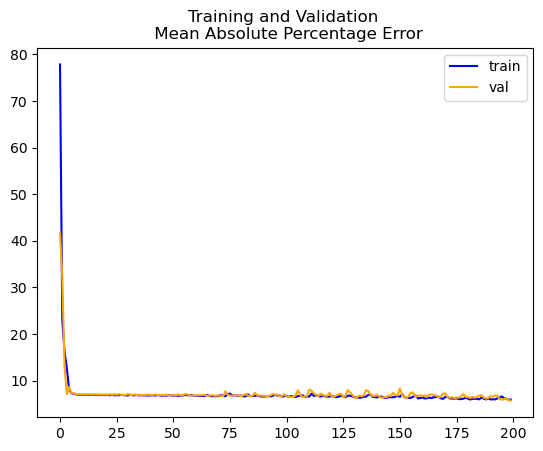

In [75]:
# FIT model with TRAINING DATA
history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)
model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

In [76]:
results = model.evaluate(test_dataset, batch_size=64)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.0000e+00 - loss: 17.9769 - mean_absolute_percentage_error: 5.9843 - mean_squared_error: 17.9769 - root_mean_squared_error: 5.5703


In [77]:
import tensorflow as tf
import numpy as np

# 重置数据集
def create_test_dataset(X_test_norm, y_test):
    return tf.data.Dataset.from_tensor_slices((X_test_norm, y_test.T)).batch(64)

# 创建测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model with TESTING DATA
results = model.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Mean Squared Error: {results[1]}')
print(f'Test Mean Absolute Percentage Error: {results[2]}')
print(f'Test Root Mean Squared Error: {results[3]}')

# PREDICT with TESTING DATA
ynew = model.predict(test_dataset)

# 重置测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model again with TESTING DATA
results = model.evaluate(test_dataset, batch_size=64)
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]} - mean_absolute_percentage_error: {results[3]} - root_mean_squared_error: {results[4]}')


Test Loss: 16.184640884399414
Test Mean Squared Error: 0.0
Test Mean Absolute Percentage Error: 16.184640884399414
Test Root Mean Squared Error: 5.730595111846924
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.0000e+00 - loss: 17.1269 - mean_absolute_percentage_error: 5.8966 - mean_squared_error: 17.1269 - root_mean_squared_error: 5.5654
loss: 16.184640884399414 - accuracy: 0.0 - mean_squared_error: 16.184640884399414 - mean_absolute_percentage_error: 5.730595111846924 - root_mean_squared_error: 5.565135955810547


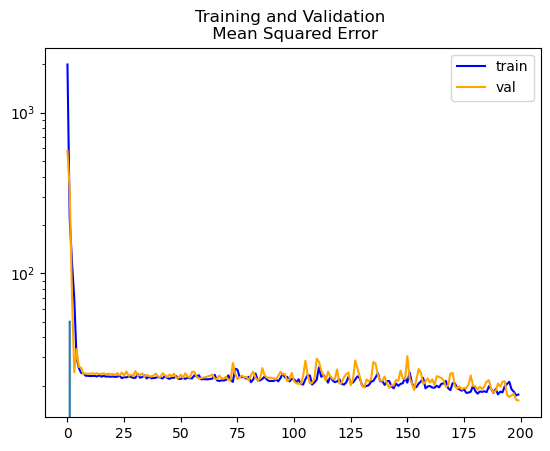

In [78]:
# plt.figure()
# plt.title('Loss (Mean Squared Error)')
# plt.plot(history.history['loss'])
# plt.figure()
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'])
# plt.figure()
# plt.title('Mean Squared Error')
# plt.plot(history.history['mean_squared_error'])
# plt.figure()
fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Squared Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['loss'], color = 'blue', label = 'train')
# plt.figure()
## Validation Plots
# plt.title('Validation Loss (MSE)') # loss = 100 * abs(y_true - y_pred) / y_true
# plt.plot(history.history['val_loss'])
# plt.figure()

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_loss'], color = 'orange', label = 'val')
ax.semilogy((0,50))
ax.legend()
# plt.figure()

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import numpy as np

y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
MSE: 4.569725993906267e+16
RMSE: 213769174.436032
MAE: 213544017.39866665
R^2: -1983108913970961.2


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
